# Prática 5

***Aprendizado Dinâmico***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**

Considere os dados RestaurantVisitors.csv, que contém dados de visitantes de restaurantes, baseado em uma <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'> competição Kaggle </a>. Os dados consideram o total de visitantes diários de quatro restaurantes localizados nos Estados Unidos, sujeitos aos feriados americanos. Para a variável exógena, utilizaremos os feriados, para verificar como eles afetam o movimento nos restaurantes. O conjunto de dados contém 478 dias de dados de restaurantes, além de 39 dias adicionais de dados de feriados para fins de previsão.


Ajuste um modelo SARIMA com uma variável exógena "holiday" usando o enfoque de modelos de espaço de estado para a variável "total". 

Faça a divisão da base em treino e teste e verifique as previsões obtidas.

Em seguida, faça a previsão para observações futuras com as informações de feriados disponíveis.

**1. Carregue as bibliotecas necessárias.**

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              


# Iniba warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


**2. Faça a leitura dos dados. Exclua as observações faltantes em total, que correspondem às observações extras de feriados.**

In [2]:
# Leitura dos dados

#pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'
df = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/Aprendizado-Dinamico/main/Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df.head()

df1 = df.dropna()

**3. Faça a visualização dos dados.**

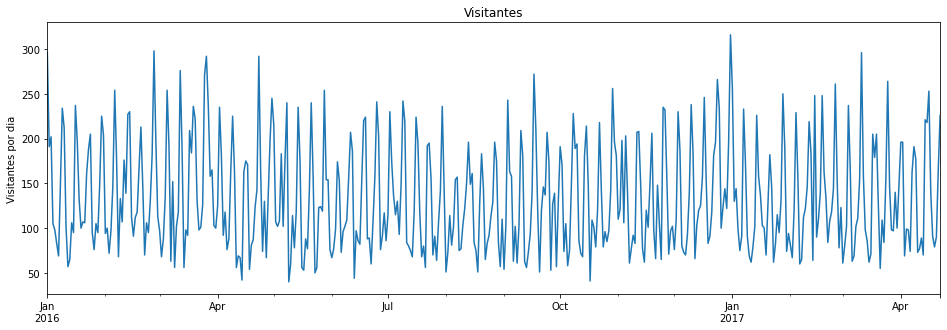

In [3]:
# Visualização dos dados

title='Visitantes'
ylabel='Visitantes por dia'
xlabel='' 

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

**4. Marque os feriados com linhas verticais em cinza.**

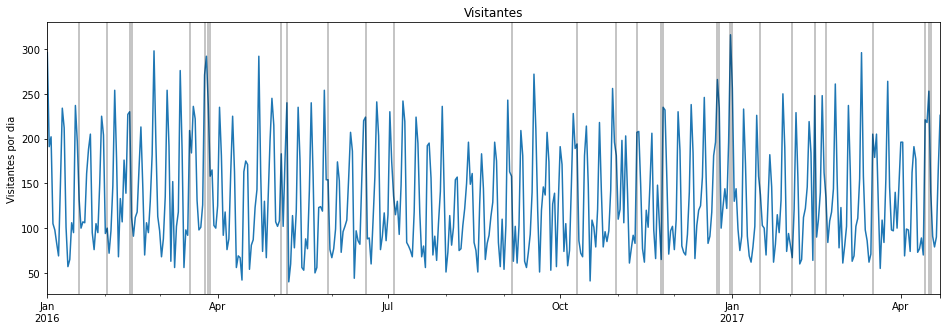

In [4]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel='' 

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

**5. Faça uma decomposição da série em tendência e sazonalidade.**

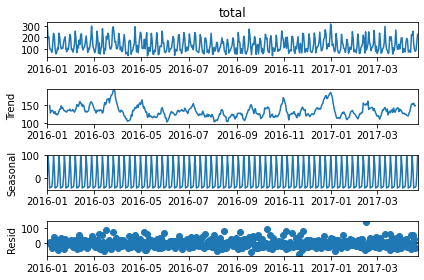

In [5]:
decomposicao = seasonal_decompose(df1['total'])
decomposicao.plot();

**6. Verifique a estacionariedade da série.**

In [6]:
# Testando estacionariedade
# fonte: https://machinelearningmastery.com/time-series-data-stationary-python/


from statsmodels.tsa.stattools import adfuller

result = adfuller(df1['total'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -5.592497
p-value: 0.000001
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


**7. Escolha um modelo SARIMA permitindo termos com sazonalidade 7.**


In [7]:
stepwise_fit = auto_arima(df1['total'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=4789.122, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5269.484, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4916.749, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5049.644, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6126.084, Time=0.00 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5093.130, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=4926.360, Time=0.11 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=4961.282, Time=1.02 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5010.582, Time=0.39 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4859.638, Time=1.14 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4845.638, Time=0.36 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2390.561
Date:                   Thu, 04 Aug 2022   AIC                           4789.122
Time:                           17:07:38   BIC                           4805.800
Sample:                                0   HQIC                          4795.679
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7574      1.993      3.391      0.001       2.852      10.663
ar.S.L7        0.9460      0.015     62.322      0.000       0.916       0.976
ma.S.L7       -0.6788      0.052    -13.128      0.000      -0.780      -0.577
sigma2      1237.2896     74.228     16.669      0.000    1091.806    1382.773
===================================================================================
Ljung-Box (L1) (Q):                  15.92   Jarque-Bera (JB):                52.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.69
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**8. Separe uma base de treino e teste. A base de treino pode ter 80% das observações totais.**


In [8]:
train = df1.iloc[:382]
test = df1.iloc[382:]

endog = train['total']
exog = train['holiday']

**9. Vamos ajustar um modelo SARIMA (0,0,0)x(1,0,1)7 para os dados de treino.**

In [9]:
# Veja https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

modelo = sm.tsa.statespace.SARIMAX(endog, exog, order=(0,0,0), seasonal_order=(1,0,1,7))
resultado = modelo.fit(disp=False)
print(resultado.summary())


                                 SARIMAX Results                                 
Dep. Variable:                     total   No. Observations:                  382
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -1842.932
Date:                   Thu, 04 Aug 2022   AIC                           3693.863
Time:                           17:07:38   BIC                           3709.645
Sample:                       01-01-2016   HQIC                          3700.124
                            - 01-16-2017                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       70.2789      5.088     13.814      0.000      60.307      80.251
ar.S.L7        0.9999   8.96e-05   1.12e+04      0.000       1.000       1.000
ma.S.L7       -0.9389      0

**10.  Obtenha os valores preditos. É importante estabelecer em predict a variável exógena.**

In [10]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # Por que não usar apenas colchetes simples?
previsao = resultado.predict(start=start, end=end, exog=exog_forecast).rename('Previsões SARIMAX(0,0,0)(1,0,1,7)')

**11. Observe as previsões do modelo e compare com a base de teste.**

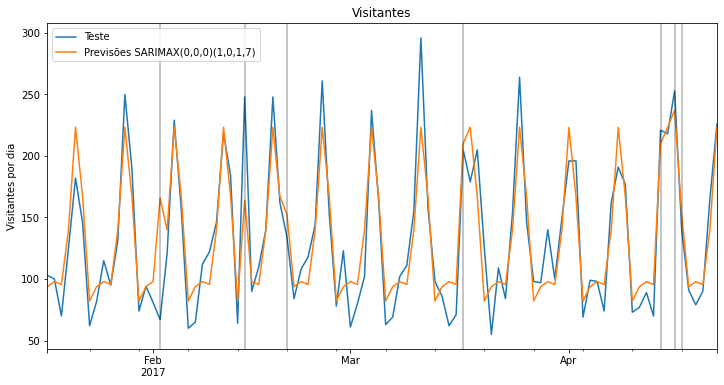

In [11]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''


ax = test['total'].plot(legend=True,figsize=(12,6),title=title, label='Teste')
previsao.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

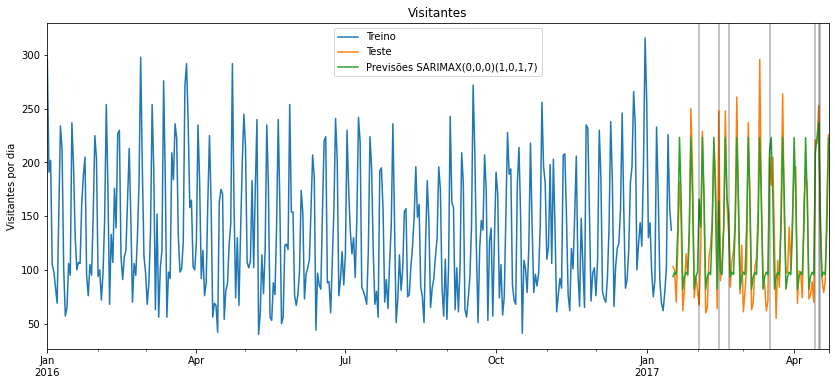

In [12]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''

train['total'].plot(legend=True,label='Treino')

ax = test['total'].plot(legend=True,figsize=(14,6),title=title, label='Teste')
previsao.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

**12. Faça as previsões para as próximas observações, com os feriados disponíveis na base. Nesse caso, não fará diferença a previsão passo à frente ou dinâmica.**

In [13]:
modelo = sm.tsa.statespace.SARIMAX(df1['total'],exog=df1['holiday'],order=(0,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
resultado = modelo.fit()
exog_forecast = df[478:][['holiday']]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25201D+00    |proj g|=  1.81617D-01

At iterate    5    f=  5.24315D+00    |proj g|=  5.41029D-02

At iterate   10    f=  5.18085D+00    |proj g|=  1.40540D-01

At iterate   15    f=  5.10640D+00    |proj g|=  1.68920D-02

At iterate   20    f=  5.09373D+00    |proj g|=  1.53519D-01

At iterate   25    f=  4.84539D+00    |proj g|=  4.98197D-01

At iterate   30    f=  4.79286D+00    |proj g|=  4.66786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N 

In [14]:
# Previsão um passo a frente. Sugestão: Use get_prediction(len(df1),len(df1)+28,exog=exog_forecast)

previsao = resultado.get_prediction(len(df1),len(df1)+38,exog=exog_forecast)
previsao_ip = previsao.conf_int()


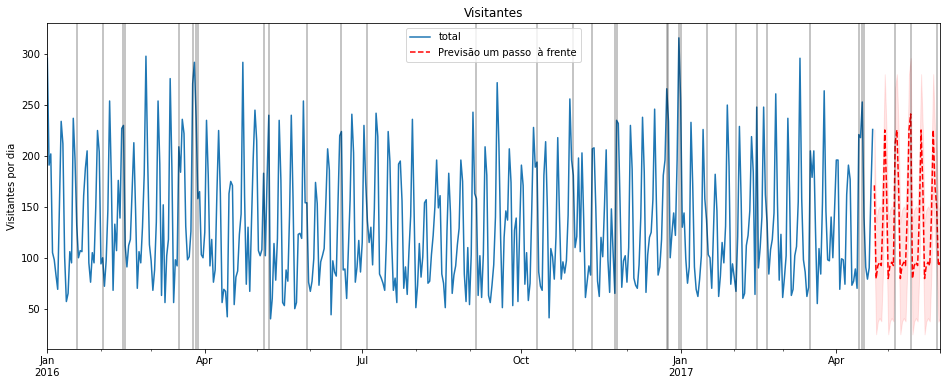

In [15]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)

previsao.predicted_mean.plot(ax=ax, style='r--', label='Previsão um passo  à frente', legend=True)
ip = previsao_ip.loc['2017-04-23':]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)


ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

**Para essa aplicação, escolher a previsão dinâmica dynamic=data_previsao_dinamica levará aos mesmos resultados na prática.**

In [16]:
# Previsão dinâmica

data_previsao_dinamica = '2017-04-23'

previsao_di = resultado.get_prediction(len(df1),len(df1)+38, dynamic=data_previsao_dinamica, exog=exog_forecast)
previsao_di_ip = previsao_di.conf_int()

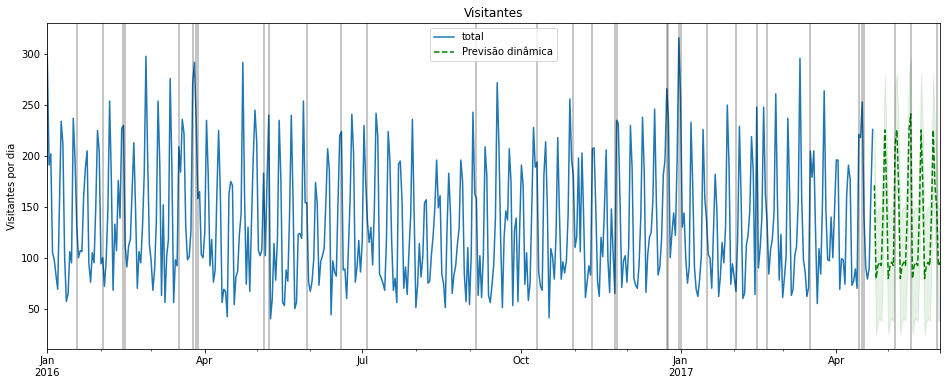

In [17]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''


ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)

previsao_di.predicted_mean.plot(ax=ax, style='g--', label='Previsão dinâmica', legend=True)
ip = previsao_di_ip.loc['2017-04-23':]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='g', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

**Prática extra:**

Ajuste e interprete um modelo Bayesiano para a demanda de eletricidade disponível em

https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html